# Deep Q-Network (DQN)
---

In [9]:
# pip install gym
# pip install torch torchvision
# pip install BOX2D

### 1. Import the Necessary Packages

In [10]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [11]:
from dqn_agent import Agent
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Random Agent

In [12]:
agent = Agent(state_size=8, action_size=4, seed=0)

for i in range(4):
    # watch an untrained agent
    state = env.reset()
    total_reward = 0
    for j in range(200):
        #action = agent.act(state)
        action = np.random.choice(np.arange(env.action_space.n))
        env.render()
        state, reward, done, _ = env.step(action)
        total_reward += 1
        #print("action:{} state:{}, reward:{}, done:{}".format(action,state,reward,done))
        if done:
            print("Total Reward = {}".format(total_reward))
            break 
        
#env.close()

Total Reward = 103
Total Reward = 101
Total Reward = 71
Total Reward = 67


In [13]:
def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
                  s[0] is the horizontal coordinate
                  s[1] is the vertical coordinate
                  s[2] is the horizontal speed
                  s[3] is the vertical speed
                  s[4] is the angle
                  s[5] is the angular speed
                  s[6] 1 if first leg has contact, else 0
                  s[7] 1 if second leg has contact, else 0
    returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a

### Agent using Heuristic policy (using state information on speed, coordinates)

In [14]:
agent = Agent(state_size=8, action_size=4, seed=0)
for i in range(6):
    state = env.reset()
    total_reward = 0
    for j in range(200):
        action = heuristic(env,state)
        env.render()
        state, reward, done, _ = env.step(action)
        total_reward += 1
        #print("action:{} state:{}, reward:{}, done:{}".format(action,state,reward,done))
        if done:
            print("Total Reward = {}".format(total_reward))
            break 
        
#env.close()

Total Reward = 193
Total Reward = 190


### 3. Train the Agent with DQN

Episode 100	Average Score: -195.04
Episode 200	Average Score: -100.22
Episode 300	Average Score: -27.607
Episode 400	Average Score: -19.83
Episode 500	Average Score: 51.005
Episode 600	Average Score: 68.79
Episode 700	Average Score: 98.737
Episode 800	Average Score: 125.06
Episode 900	Average Score: 193.46
Episode 918	Average Score: 200.90
Environment solved in 818 episodes!	Average Score: 200.90


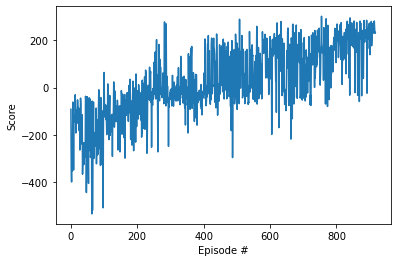

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Trained Agent

Load the trained weights from file to watch a trained Agent

In [15]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(6):
    state = env.reset()
    total_reward = 0
    for j in range(2000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            print("Total Reward = {}".format(total_reward))
            break 
            
#env.close()

Total Reward = -64.04164987844759
Total Reward = 255.56757306350718
Total Reward = 202.31829568338628
Total Reward = 223.71078635689489
Total Reward = 250.64643937062027
Total Reward = 76.42582415745422


In [8]:
env.close()